# Feature Selection for Uplift Modeling
  
    
This notebook includes two sections:  
- **Feature selection**: demonstrate how to use Filter methods to select the most important numeric features
- **Performance evaluation**: evaluate the AUUC performance with top features dataset
  
*(Paper reference: [Zhao, Zhenyu, et al. "Feature Selection Methods for Uplift Modeling." arXiv preprint arXiv:2005.03447 (2020).](https://arxiv.org/abs/2005.03447))*

In [1]:
import numpy as np
import pandas as pd

In [2]:
from causalml.dataset import make_uplift_classification

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


#### Import FilterSelect class for Filter methods

In [3]:
from causalml.feature_selection.filters import FilterSelect

In [4]:
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [6]:
import logging

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

### Generate dataset

Generate synthetic data using the built-in function.

In [7]:
# define parameters for simulation

y_name = 'conversion'
treatment_group_keys = ['control', 'treatment1']
n = 10000
n_classification_features = 50
n_classification_informative = 10
n_classification_repeated = 0
n_uplift_increase_dict = {'treatment1': 8}
n_uplift_decrease_dict = {'treatment1': 4}
delta_uplift_increase_dict = {'treatment1': 0.1}
delta_uplift_decrease_dict = {'treatment1': -0.1}

random_seed = 20200808

In [8]:
df, X_names = make_uplift_classification(
    treatment_name=treatment_group_keys,
    y_name=y_name,
    n_samples=n,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_classification_repeated=n_classification_repeated,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict = delta_uplift_increase_dict, 
    delta_uplift_decrease_dict = delta_uplift_decrease_dict,
    random_seed=random_seed
)

In [9]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x56_uplift_increase,x57_uplift_increase,x58_uplift_increase,x59_increase_mix,x60_uplift_decrease,x61_uplift_decrease,x62_uplift_decrease,x63_uplift_decrease,conversion,treatment_effect
0,treatment1,-4.004496,-1.250351,-2.800557,-0.368288,-0.115549,-2.492826,0.369516,0.290526,0.465153,...,0.496144,1.847680,-0.337894,-0.672058,1.180352,0.778013,0.931000,2.947160,0,0
1,treatment1,-3.170028,-0.135293,1.484246,-2.131584,-0.760103,1.764765,0.972124,1.407131,-1.027603,...,0.574955,3.578138,0.678118,-0.545227,-0.143942,-0.015188,1.189643,1.943692,1,0
2,treatment1,-0.763386,-0.785612,1.218781,-0.725835,1.044489,-1.521071,-2.266684,-1.614818,-0.113647,...,0.985076,1.079181,0.578092,0.574370,-0.477429,0.679070,1.650897,2.768897,1,0
3,control,0.887727,0.049095,-2.242776,1.530966,0.392623,-0.203071,-0.549329,0.107296,-0.542277,...,-0.175352,0.683330,0.567545,0.349622,-0.789203,2.315184,0.658607,1.734836,0,0
4,control,-1.672922,-1.156145,3.871476,-1.883713,-0.220122,-4.615669,0.141980,-0.933756,-0.765592,...,0.485798,-0.355315,0.982488,-0.007260,2.895155,0.261848,-1.337001,-0.639983,1,0


In [10]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.50180,10000
treatment1,0.59750,10000
All,0.54965,20000


In [11]:
X_names

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_informative',
 'x7_informative',
 'x8_informative',
 'x9_informative',
 'x10_informative',
 'x11_irrelevant',
 'x12_irrelevant',
 'x13_irrelevant',
 'x14_irrelevant',
 'x15_irrelevant',
 'x16_irrelevant',
 'x17_irrelevant',
 'x18_irrelevant',
 'x19_irrelevant',
 'x20_irrelevant',
 'x21_irrelevant',
 'x22_irrelevant',
 'x23_irrelevant',
 'x24_irrelevant',
 'x25_irrelevant',
 'x26_irrelevant',
 'x27_irrelevant',
 'x28_irrelevant',
 'x29_irrelevant',
 'x30_irrelevant',
 'x31_irrelevant',
 'x32_irrelevant',
 'x33_irrelevant',
 'x34_irrelevant',
 'x35_irrelevant',
 'x36_irrelevant',
 'x37_irrelevant',
 'x38_irrelevant',
 'x39_irrelevant',
 'x40_irrelevant',
 'x41_irrelevant',
 'x42_irrelevant',
 'x43_irrelevant',
 'x44_irrelevant',
 'x45_irrelevant',
 'x46_irrelevant',
 'x47_irrelevant',
 'x48_irrelevant',
 'x49_irrelevant',
 'x50_irrelevant',
 'x51_uplift_increase',
 'x52_uplift_increase',
 

## Feature selection with Filter methods

### method = F (F Filter)

In [12]:
filter_method = FilterSelect() 

In [13]:
# F Filter with order 1
method = 'F'
f_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x53_uplift_increase,1.0,190.321410,4.262512e-43,"df_num: 1.0, df_denom: 19996.0, order:1"
0,F filter,x57_uplift_increase,2.0,127.136380,2.127676e-29,"df_num: 1.0, df_denom: 19996.0, order:1"
0,F filter,x3_informative,3.0,66.273458,4.152970e-16,"df_num: 1.0, df_denom: 19996.0, order:1"
0,F filter,x4_informative,4.0,59.407590,1.341417e-14,"df_num: 1.0, df_denom: 19996.0, order:1"
0,F filter,x62_uplift_decrease,5.0,3.957507,4.667636e-02,"df_num: 1.0, df_denom: 19996.0, order:1"


In [14]:
# F Filter with order 2
method = 'F'
f_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1', order=2)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x53_uplift_increase,1.0,107.368286,4.160720e-47,"df_num: 2.0, df_denom: 19994.0, order:2"
0,F filter,x57_uplift_increase,2.0,70.138050,4.423736e-31,"df_num: 2.0, df_denom: 19994.0, order:2"
0,F filter,x3_informative,3.0,36.499465,1.504356e-16,"df_num: 2.0, df_denom: 19994.0, order:2"
0,F filter,x4_informative,4.0,31.780547,1.658731e-14,"df_num: 2.0, df_denom: 19994.0, order:2"
0,F filter,x55_uplift_increase,5.0,27.494904,1.189886e-12,"df_num: 2.0, df_denom: 19994.0, order:2"


In [15]:
# F Filter with order 3
method = 'F'
f_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1', order=3)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x53_uplift_increase,1.0,72.064224,2.373628e-46,"df_num: 3.0, df_denom: 19992.0, order:3"
0,F filter,x57_uplift_increase,2.0,46.841718,3.710784e-30,"df_num: 3.0, df_denom: 19992.0, order:3"
0,F filter,x3_informative,3.0,24.089980,1.484634e-15,"df_num: 3.0, df_denom: 19992.0, order:3"
0,F filter,x4_informative,4.0,23.097310,6.414267e-15,"df_num: 3.0, df_denom: 19992.0, order:3"
0,F filter,x55_uplift_increase,5.0,18.072880,1.044117e-11,"df_num: 3.0, df_denom: 19992.0, order:3"


### method = LR (likelihood ratio test)

In [16]:
# LR Filter with order 1
method = 'LR'
lr_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
lr_imp.head()

,method,feature,rank,score,p_value,misc
0,LR filter,x53_uplift_increase,1.0,203.811674,0.000000e+00,"df: 1, order: 1"
0,LR filter,x57_uplift_increase,2.0,133.175328,0.000000e+00,"df: 1, order: 1"
0,LR filter,x3_informative,3.0,64.366711,9.992007e-16,"df: 1, order: 1"
0,LR filter,x4_informative,4.0,52.389798,4.550804e-13,"df: 1, order: 1"
0,LR filter,x62_uplift_decrease,5.0,4.064347,4.379760e-02,"df: 1, order: 1"


In [17]:
# LR Filter with order 2
method = 'LR'
lr_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1',order=2)
lr_imp.head()

,method,feature,rank,score,p_value,misc
0,LR filter,x53_uplift_increase,1.0,277.639095,0.000000e+00,"df: 2, order: 2"
0,LR filter,x57_uplift_increase,2.0,156.134112,0.000000e+00,"df: 2, order: 2"
0,LR filter,x55_uplift_increase,3.0,71.478979,3.330669e-16,"df: 2, order: 2"
0,LR filter,x3_informative,4.0,44.938973,1.744319e-10,"df: 2, order: 2"
0,LR filter,x4_informative,5.0,29.179971,4.609458e-07,"df: 2, order: 2"


In [18]:
# LR Filter with order 3
method = 'LR'
lr_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1',order=3)
lr_imp.head()

,method,feature,rank,score,p_value,misc
0,LR filter,x53_uplift_increase,1.0,290.389201,0.000000e+00,"df: 3, order: 3"
0,LR filter,x57_uplift_increase,2.0,153.942614,0.000000e+00,"df: 3, order: 3"
0,LR filter,x55_uplift_increase,3.0,70.626667,3.108624e-15,"df: 3, order: 3"
0,LR filter,x3_informative,4.0,45.477851,7.323235e-10,"df: 3, order: 3"
0,LR filter,x4_informative,5.0,30.466528,1.100881e-06,"df: 3, order: 3"


### method = KL (KL divergence)

In [19]:
method = 'KL'
kl_imp = filter_method.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1',
                      n_bins=10)
kl_imp.head()

,method,feature,rank,score,p_value,misc
0,KL filter,x53_uplift_increase,1.0,0.022997,None,number_of_bins: 10
0,KL filter,x57_uplift_increase,2.0,0.014884,None,number_of_bins: 10
0,KL filter,x4_informative,3.0,0.012103,None,number_of_bins: 10
0,KL filter,x3_informative,4.0,0.010179,None,number_of_bins: 10
0,KL filter,x55_uplift_increase,5.0,0.003836,None,number_of_bins: 10


We found all these 3 filter methods were able to rank most of the **informative** and **uplift increase** features on the top.

## Performance evaluation  

Evaluate the AUUC (Area Under the Uplift Curve) score with several uplift models when using top features dataset 

In [20]:
# train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [21]:
# convert treatment column to 1 (treatment1) and 0 (control)
treatments = np.where((df_test['treatment_group_key']=='treatment1'), 1, 0)
print(treatments[:10])
print(df_test['treatment_group_key'][:10])

[0 0 1 1 0 1 1 0 0 0]
18998       control
11536       control
8552     treatment1
2652     treatment1
19671       control
13244    treatment1
3075     treatment1
8746        control
18530       control
5066        control
Name: treatment_group_key, dtype: object


### Uplift RandomForest Classfier

In [22]:
uplift_model = UpliftRandomForestClassifier(control_name='control', max_depth=8)

In [23]:
# using all features
features = X_names 
uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds = uplift_model.predict(df_test[features].values)

### Select top N features based on KL filter

In [24]:
top_n = 10
top_10_features = kl_imp['feature'][:top_n]
print(top_10_features)

0    x53_uplift_increase
0    x57_uplift_increase
0         x4_informative
0         x3_informative
0    x55_uplift_increase
0         x1_informative
0    x56_uplift_increase
0    x51_uplift_increase
0         x38_irrelevant
0    x58_uplift_increase
Name: feature, dtype: object


In [25]:
top_n = 15
top_15_features = kl_imp['feature'][:top_n]
print(top_15_features)

0    x53_uplift_increase
0    x57_uplift_increase
0         x4_informative
0         x3_informative
0    x55_uplift_increase
0         x1_informative
0    x56_uplift_increase
0    x51_uplift_increase
0         x38_irrelevant
0    x58_uplift_increase
0         x48_irrelevant
0         x15_irrelevant
0         x27_irrelevant
0    x62_uplift_decrease
0         x23_irrelevant
Name: feature, dtype: object


In [26]:
top_n = 20
top_20_features = kl_imp['feature'][:top_n]
print(top_20_features)

0    x53_uplift_increase
0    x57_uplift_increase
0         x4_informative
0         x3_informative
0    x55_uplift_increase
0         x1_informative
0    x56_uplift_increase
0    x51_uplift_increase
0         x38_irrelevant
0    x58_uplift_increase
0         x48_irrelevant
0         x15_irrelevant
0         x27_irrelevant
0    x62_uplift_decrease
0         x23_irrelevant
0         x29_irrelevant
0         x6_informative
0         x45_irrelevant
0         x40_irrelevant
0         x25_irrelevant
Name: feature, dtype: object


#### Train the Uplift model again with top N features

In [27]:
# using top 10 features
features = top_10_features 

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t10 = uplift_model.predict(df_test[features].values)

In [28]:
# using top 15 features
features = top_15_features 

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t15 = uplift_model.predict(df_test[features].values)

In [29]:
# using top 20 features
features = top_20_features

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t20 = uplift_model.predict(df_test[features].values)

### Print results for Uplift model

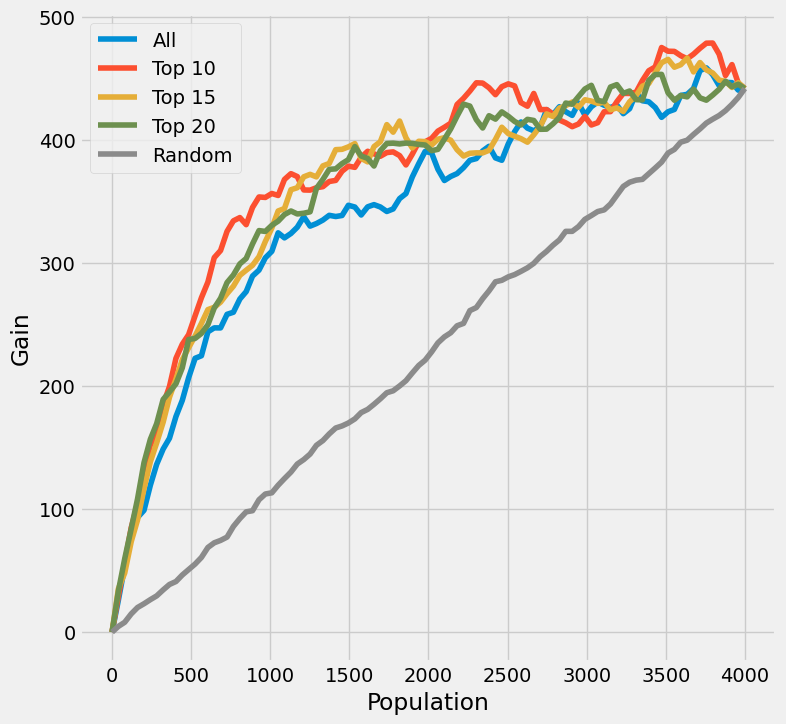

In [30]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')


In [31]:
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.773405
Top 10    0.841204
Top 15    0.816100
Top 20    0.816252
Random    0.506801
dtype: float64

### R Learner as base and feed in Random Forest Regressor

In [32]:
r_rf_learner = BaseRRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
control_name='control') 

In [33]:
# using all features
features = X_names 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [34]:
# using top 10 features
features = top_10_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t10 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [35]:
# using top 15 features
features = top_15_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t15 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [36]:
# using top 20 features
features = top_20_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t20 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score


INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


### Print results for R Learner

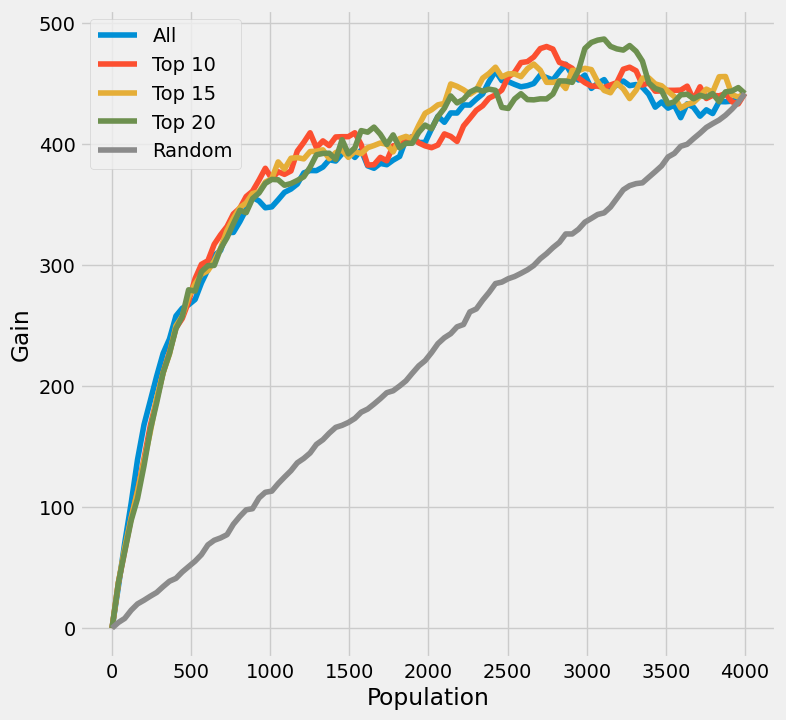

In [37]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')

In [38]:
# print out AUUC score
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.856210
Top 10    0.867637
Top 15    0.869827
Top 20    0.867636
Random    0.506801
dtype: float64

(a relatively smaller enhancement on the AUUC is observed in this R Learner case)

### S Learner as base and feed in Random Forest Regressor

In [39]:
slearner_rf = BaseSRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
    control_name='control')

In [40]:
# using all features
features = X_names 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds = slearner_rf.predict(df_test[features].values)

In [41]:
# using top 10 features
features = top_10_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t10 = slearner_rf.predict(df_test[features].values)

In [42]:
# using top 15 features
features = top_15_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t15 = slearner_rf.predict(df_test[features].values)

In [43]:
# using top 20 features
features = top_20_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t20 = slearner_rf.predict(df_test[features].values)

### Print results for S Learner

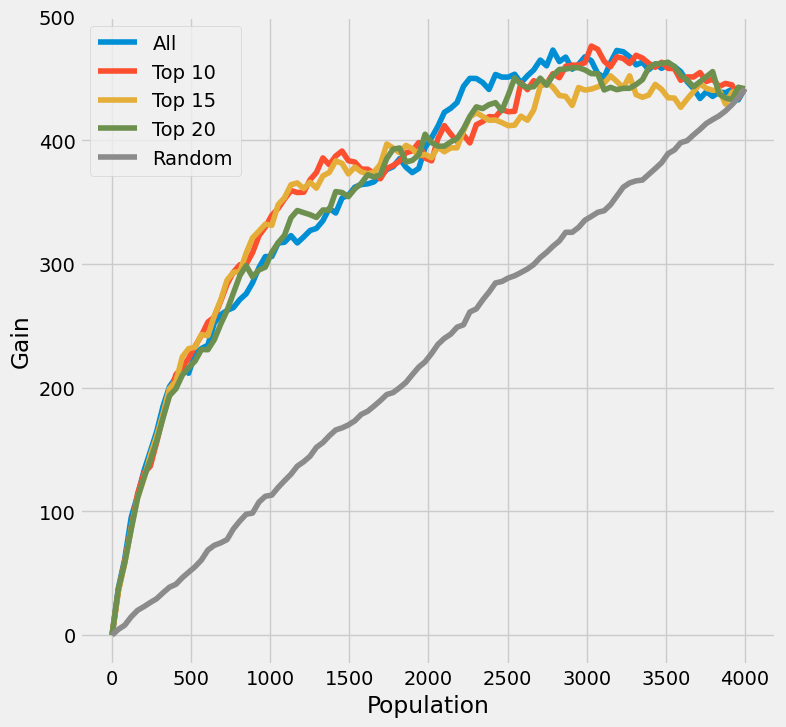

In [44]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')

In [45]:
# print out AUUC score
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.824483
Top 10    0.832872
Top 15    0.817835
Top 20    0.816149
Random    0.506801
dtype: float64

In this notebook, we demonstrated how our Filter method functions are able to select important features and enhance the AUUC performance (while the results might vary among different datasets, models and hyper-parameters).